In [1]:
%load_ext autoreload
%autoreload 2
from src.chem_draw import draw_rxn_svg, draw_pwy_svg
from src.utils import sort_x_by_y, ensure_dirs
from svgutils import compose as sc
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

In [2]:
# Params
expansion_dir = '../data/processed_expansions/'
fn = "ccm_v0_to_mvacid_gen_4_tan_sample_1_n_samples_1000.pk" # Expansion file name
rxns_path = expansion_dir + 'predicted_reactions_' + fn
paths_path = expansion_dir + 'paths_' + fn

In [3]:
# Load reactions and paths
with open(rxns_path, 'rb') as f:
    pred_rxns = pickle.load(f)

with open(paths_path, 'rb') as f:
    paths = pickle.load(f)

In [4]:
# Count how many pathways have full info

for k,v in paths.items():
    n_paths_w_full_info = 0
    for p in v:
        path_full_info = []
        for rh in p.rhashes:
            full_info = False
            for elt in pred_rxns[rh].known_rxns:
                if elt[0] is not None:
                    full_info = True
                    break

            path_full_info.append(full_info)
        
        if all(path_full_info):
            n_paths_w_full_info += 1

    print(k, ":", n_paths_w_full_info / len(v), len(v))


('fumarate', 'mvacid') : 0.7432675044883303 557
('succinate', 'mvacid') : 0.7058823529411765 17
('pyruvate', 'mvacid') : 1.0 3
('acetate', 'mvacid') : 1.0 2


In [5]:
# Sort known reactions by average (could alter the sort by value)
for k in pred_rxns.keys():
    pred_rxns[k].sort_known_rxns()

In [6]:
# Set prc mcs attribute for each path by averaging over 
# known reactions
for st_pair in paths:
    for p in paths[st_pair]:
        p.compute_mean_prc_mcs(pred_rxns)

In [7]:
# # Sort paths by min reaction prc mcs
# min_prc_mcs = []
# for p in paths:
#     min_prc_mcs.append(p.min_mcs())

# min_sorted_idxs = np.arange(len(paths))

# min_sorted_idxs, min_prc_mcs = sort_x_by_y(min_sorted_idxs, min_prc_mcs, reverse=True)

# plt.hist(min_prc_mcs)
# plt.show()

In [8]:
# # Sort paths by min reaction prc mcs
# mean_prc_mcs = []
# for p in paths:
#     mean_prc_mcs.append(p.mean_mcs())

# mean_sorted_idxs = np.arange(len(paths))

# mean_sorted_idxs, mean_prc_mcs = sort_x_by_y(mean_sorted_idxs, mean_prc_mcs, reverse=True)

# plt.hist(mean_prc_mcs)
# plt.show()

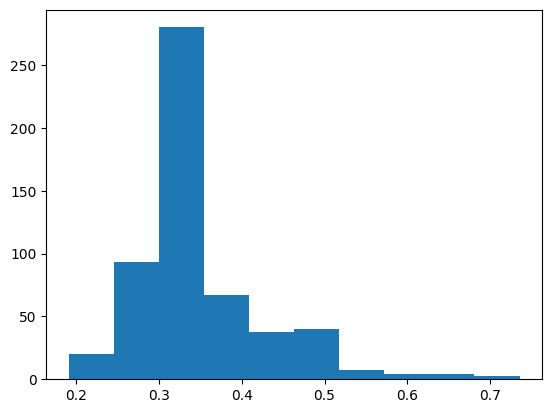

In [10]:
# First sort by min prc_mcs and threshold and then sort by mean prc_mcs

min_thresh = 0.05
st_pair = ('fumarate', 'mvacid')

# Get min prc_mcs
min_prc_mcs = []
for p in paths[st_pair]:
    min_prc_mcs.append(p.min_mcs())

# Sort indices by min prc_mcs
min_sorted_idxs = np.arange(len(paths[st_pair]))
min_sorted_idxs, min_prc_mcs = sort_x_by_y(min_sorted_idxs, min_prc_mcs, reverse=True)

# Remove zero mins
min_sorted_idxs, min_prc_mcs = np.array(min_sorted_idxs), np.array(min_prc_mcs)
min_sorted_idxs = min_sorted_idxs[min_sorted_idxs > min_thresh]

# Get mean prc_mcs of non-zero min paths
mean_prc_mcs = []
for idx in min_sorted_idxs:
    mean_prc_mcs.append(paths[st_pair][idx].mean_mcs())

min_mean_sorted_idxs, mean_prc_mcs = sort_x_by_y(min_sorted_idxs, mean_prc_mcs, reverse=True)

plt.hist(mean_prc_mcs)
plt.show()

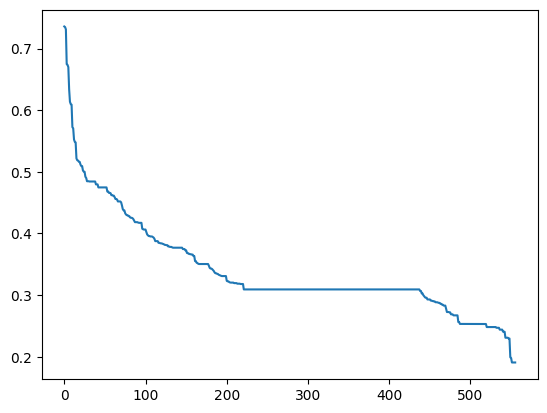

In [11]:
plt.plot(mean_prc_mcs)
plt.show()

In [15]:
# Generate pwy svgs

n_pwys = 20
pwy_svg_outdir = f"../artifacts/pwy_svgs/{fn[:-3]}/{'_'.join(st_pair)}/"
ensure_dirs(pwy_svg_outdir)

for i in range(n_pwys):
    pwy_idx = min_mean_sorted_idxs[i]
    sma_hash_pairs = []
    this_rhashes = paths[st_pair][pwy_idx].rhashes
    for this_rhash in this_rhashes:
        this_rxn = pred_rxns[this_rhash]
        sma_hash_pairs.append([(this_rxn.smarts, this_rhash), (this_rxn.known_rxns[0][1], hash(this_rxn.known_rxns[0][1]))])

    outpath = pwy_svg_outdir + f"{i:03}_{pwy_idx}.svg"
    draw_pwy_svg(sma_hash_pairs, outpath)

FileNotFoundError: [Errno 2] No such file or directory: './../artifacts/mol_svgs/double_border.svg'

In [13]:
# Convert svgs to pdfs

tmp_pdf_outdir = f"../artifacts/tmp_pdfs/{fn[:-3]}/{'_'.join(st_pair)}/"
ensure_dirs(tmp_pdf_outdir)
for elt in os.listdir(pwy_svg_outdir):
    cmd = ["inkscape", f"--export-pdf={tmp_pdf_outdir}{elt[:-3]}pdf", f"{pwy_svg_outdir}{elt}"]
    subprocess.run(cmd)

In [14]:
# Concatenate pdfs
pwy_pdf_outdir = f"../artifacts/pwy_pdfs/{fn[:-3]}/"
ensure_dirs(pwy_pdf_outdir)
cat_pdf_fn = pwy_pdf_outdir + '_'.join(st_pair) + '.pdf'
individual_pwys = sorted(list(os.listdir(tmp_pdf_outdir)))
individual_pwys = [tmp_pdf_outdir + elt for elt in individual_pwys]
if cat_pdf_fn in individual_pwys:
    individual_pwys.remove(cat_pdf_fn)
cmd = ["pdfunite", *individual_pwys, cat_pdf_fn]
subprocess.run(cmd)

pdfunite version 0.86.1
Copyright 2005-2020 The Poppler Developers - http://poppler.freedesktop.org
Copyright 1996-2011 Glyph & Cog, LLC
Usage: pdfunite [options] <PDF-sourcefile-1>..<PDF-sourcefile-n> <PDF-destfile>
  -v             : print copyright and version info
  -h             : print usage information
  -help          : print usage information
  --help         : print usage information
  -?             : print usage information


CompletedProcess(args=['pdfunite', '../artifacts/pwy_pdfs/ccm_v0_to_mvacid_gen_4_tan_sample_1_n_samples_1000/fumarate_mvacid.pdf'], returncode=99)